# k-Means

# 1)- Importing key Modules


In [23]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [24]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time

# 2)-Loading Data

In [26]:
nba = pd.read_csv("nba_2013.csv")
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


# 3)-k-Means

In [27]:
kmeans = KMeans(n_clusters=5, random_state=1)
numeric_cols = nba._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

# 4)- PCA

Text(0.5, 1.0, 'PCA')

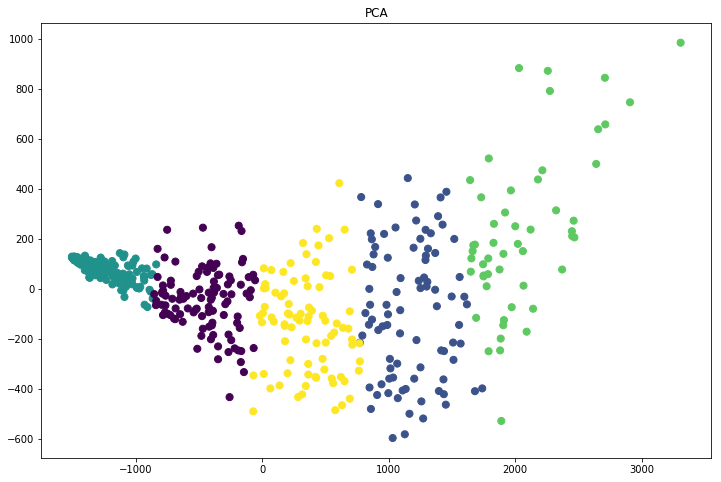

In [28]:
# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

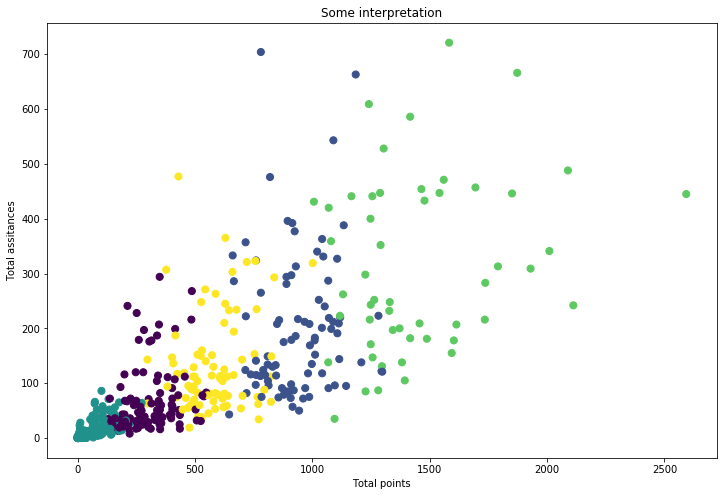

In [29]:
# Visualizing using 2 features: Total points vs. Total assists
plt.figure(figsize=(12,8))
plt.scatter(nba['pts'], nba['ast'], 
            c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Total points')
plt.ylabel('Total assitances')
plt.title('Some interpretation');

# 5)- Compressing images with k-Means

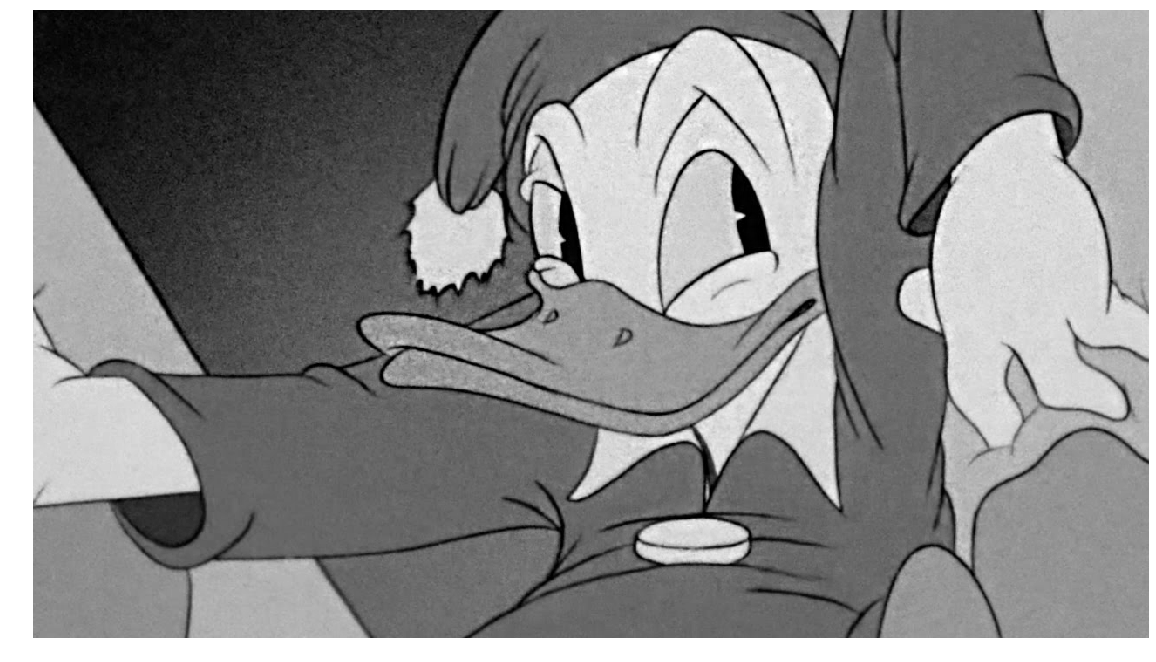

In [30]:
import matplotlib.image as mpimg
img = mpimg.imread('donald.jpg')[..., 1]
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img, cmap='gray');

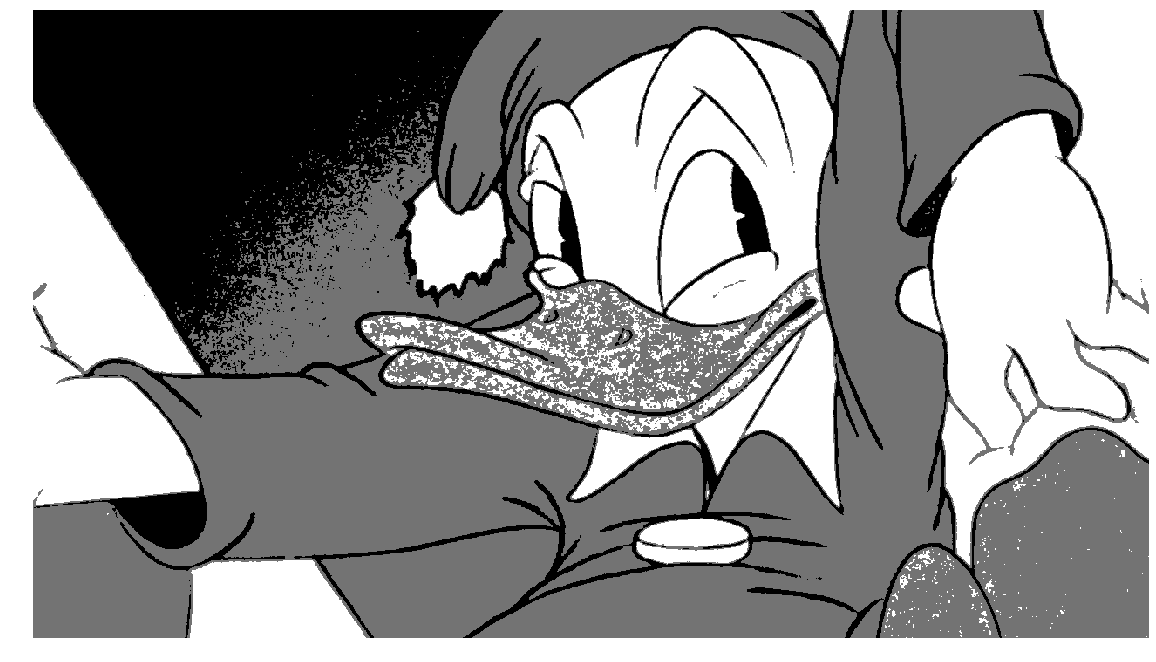

In [31]:
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import randint

X = img.reshape((-1, 1))
k_means = MiniBatchKMeans(n_clusters=3)
k_means.fit(X) 
values = k_means.cluster_centers_
labels = k_means.labels_
img_compressed = values[labels].reshape(img.shape)
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img_compressed, cmap = 'gray');

# 6)-Finding latent topics in texts

aka Topic Modeling

In [32]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [33]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [34]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

3387 documents
4 categories


In [35]:
labels = dataset.target
true_k = np.unique(labels).shape[0]

### Tf-Idf

In [36]:
print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
n_samples: 3387, n_features: 1000


### k-Means to text

In [37]:
km = KMeans(n_clusters=true_k, init='k-means++', 
            max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.501
Completeness: 0.586
V-measure: 0.540
Adjusted Rand-Index: 0.491
Silhouette Coefficient: 0.016


In [39]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

### Output words that are close to cluster centers

In [40]:
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: access digex pat prb net hst online communications com usa
Cluster 2: god com people article don sandvik say jesus keith think
Cluster 3: space nasa henry gov toronto moon alaska launch shuttle orbit
Cluster 4: graphics com university posting thanks host nntp image ac computer


# 7)- handwritten digits dataset

In [41]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

In [42]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y, kmeans.predict(X))

0.6631204781338814

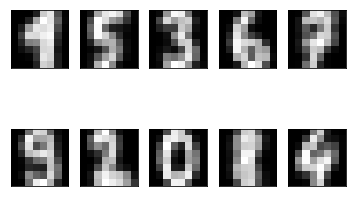

In [44]:
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), kmeans.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())